In [625]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from shapely import Point, Polygon
from pyproj import Proj


In [626]:
def read_jgw_file(jgw_file_path):
    with open(jgw_file_path, 'r') as jgw_file:
        lines = jgw_file.readlines()
        transformation_params = {
            'A': float(lines[0].strip()),  # Pixel width
            'D': float(lines[1].strip()),  # Rotation parameter
            'B': float(lines[2].strip()),  # Rotation parameter
            'E': float(lines[3].strip()),  # Pixel height
            'C': float(lines[4].strip()),  # x-coordinate of the upper-left corner of the image
            'F': float(lines[5].strip())   # y-coordinate of the upper-left corner of the image
        }
    return transformation_params

In [627]:

def utm_to_lat_long(easting, norting, zone=14, ellps='WGS84', hemisphere='N'):
    """
    """
    proj = Proj(proj='utm', zone=zone, ellps=ellps, hemisphere=hemisphere)
    lon, lat = proj(easting, norting, inverse=True)
    
    return lon, lat
    
    

In [628]:
def mask_to_coordinates(image, mask, transformation):
    """
    compute and convert pixel to gps coordinates
    """
    # unpack transformation params
    x_top_left = transformation['C']
    y_top_left = transformation['F']
    pixel_size_x = transformation['A']
    pixel_size_y = transformation['E']
    # find contours from the binary mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # compute pixel coords of each parking stall and convert it to GPS coords
    polygons = []
    vertices = []
    for contour in contours:
        contour = contour.reshape(-1, 2)
        v = []
        p = []
        bbox = cv2.boundingRect(contour)
        bb_x, bb_y, bb_w, bb_h = bbox
        bb_corners = [(bb_x, bb_y), (bb_x + bb_w, bb_y), (bb_x + bb_w, bb_y + bb_h), (bb_x, bb_y + bb_h)]
        #print(contour[np.argmax(contour[:, 0])])
        max_x = False
        min_x = False
        max_y = False
        min_y = False
        found = False
        for px, py in contour:
            #if (bb_x <= px <= bb_x + bb_w) and (bb_y <= py <= bb_y + bb_h):  
            if px == contour[np.argmax(contour[:, 0])][0] and max_x == False:
                found = True
                max_x = True
            elif px == contour[np.argmin(contour[:, 0])][0] and min_x == False:
                found = True
                min_x = True
            elif py == contour[np.argmax(contour[:, 1])][1] and max_y == False:
                found = True
                max_y = True
            elif py == contour[np.argmin(contour[:, 1])][1] and min_y == False:
                found = True
                min_y = True
            
            if found:
                x = x_top_left + (px * pixel_size_x)
                y = y_top_left + (py * pixel_size_y)
                lon, lat = utm_to_lat_long(easting=x, norting=y, zone=14, ellps='WGS84', hemisphere='N')
                p.append(Point(lon, lat))
                v.append((x, y))
                found = False
            
        if len(p) > 3:        
            polygons.append(Polygon([(point.x, point.y) for point in p]))
            vertices.append(v)
        
    return polygons, vertices

In [629]:
transformation = read_jgw_file("media/georeference.jgw")

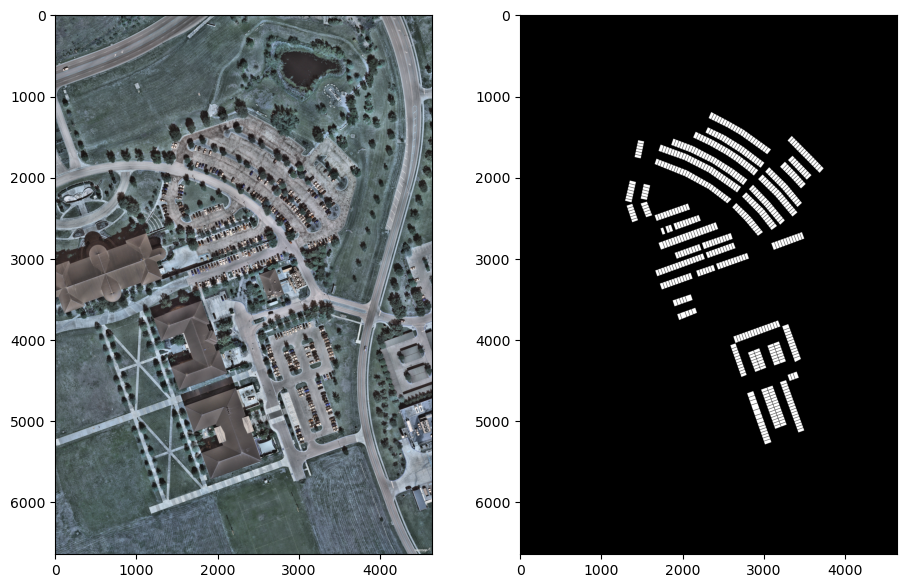

In [630]:
image = cv2.imread("media/satellite.jpg", cv2.COLOR_BGR2RGB)
mask = cv2.imread("media/mask.png", 0)

plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(mask, 'gray')

plt.show()


In [631]:
polygons, vertices = mask_to_coordinates(image, mask, transformation)

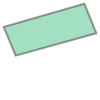

In [632]:
polygons[1]

In [633]:
vertices[0]

[(629134.478337, 3382375.659457),
 (629128.6559489999, 3382373.6440149997),
 (629129.700993, 3382370.807467),
 (629135.5233809999, 3382372.897555)]

In [634]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(geometry=polygons)

In [635]:
gdf.head()

,geometry
0,"POLYGON ((-97.65343 30.56689, -97.65349 30.566..."
1,"POLYGON ((-97.65344 30.56691, -97.65350 30.566..."
2,"POLYGON ((-97.65345 30.56694, -97.65351 30.566..."
3,"POLYGON ((-97.65346 30.56696, -97.65352 30.566..."
4,"POLYGON ((-97.65312 30.56698, -97.65317 30.566..."


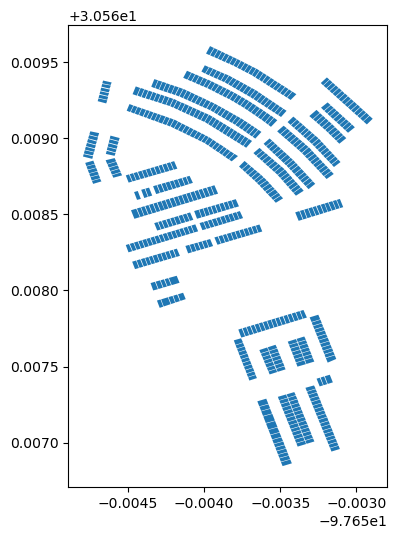

In [636]:
gdf.plot(figsize=(6, 6))
plt.show()

In [637]:
gdf = gdf.set_crs('EPSG:4326')
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [638]:
gdf.head()

,geometry
0,"POLYGON ((-97.65343 30.56689, -97.65349 30.566..."
1,"POLYGON ((-97.65344 30.56691, -97.65350 30.566..."
2,"POLYGON ((-97.65345 30.56694, -97.65351 30.566..."
3,"POLYGON ((-97.65346 30.56696, -97.65352 30.566..."
4,"POLYGON ((-97.65312 30.56698, -97.65317 30.566..."


In [639]:
geojson = gdf.to_json()

In [640]:
gdf.to_file("output.geojson", driver="GeoJSON")
gdf.to_file("output.shp")


In [643]:
m = leafmap.Map(height='700px')
# Add Google satellite basemap
m.add_basemap('SATELLITE')

m.add_vector('output.shp', layer_name='Parking', zoom_to_layer=True, info_mode='on_click')

m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…